## Dblp dataset, (Normalized Louvain, Influential Node), Modularity, Conductance

In [4]:
import numpy as np
import pandas as pd
import networkx as nx
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
import community

In [5]:
# Load the dataset
data = np.load('/kaggle/input/dblp-data/dblp.npz')

# Extract relevant data
adj_data = data['adj_data']
adj_indices = data['adj_indices']
adj_indptr = data['adj_indptr']
attr_data = data['attr_data']
attr_indices = data['attr_indices']
attr_indptr = data['attr_indptr']
labels = data['labels']
# Number of nodes (entities) in the network
num_nodes = len(adj_indptr) - 1

# Number of edges in the network
num_edges = len(adj_data)

# Print the details
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)


Number of nodes: 4230
Number of edges: 5358


# Cosine similarity

In [6]:
import numpy as np
import community  
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from scipy import sparse
adj_matrix = sparse.csr_matrix((adj_data, adj_indices, adj_indptr))

# Calculate cosine similarity for topology information
adj_cosine_similarity = cosine_similarity(adj_matrix)

# Normalize adjacency cosine similarity matrix
adj_cosine_similarity_normalized = normalize(adj_cosine_similarity)

# Calculate cosine similarity for attributes
attr_matrix = sparse.csr_matrix((attr_data, attr_indices, attr_indptr))
attr_cosine_similarity = cosine_similarity(attr_matrix)

# Normalize attributes cosine similarity matrix
attr_cosine_similarity_normalized = normalize(attr_cosine_similarity)

# Normalize

In [7]:
# Define weights for topology and attributes
weight_topology = 0.95
weight_attributes = 0.000655

# Combine similarities with weights
combined_similarity = (weight_topology * adj_cosine_similarity_normalized) + (weight_attributes * attr_cosine_similarity_normalized)

# Normalize the combined similarity matrix
min_value = np.min(combined_similarity)
max_value = np.max(combined_similarity)
normalized_similarity = (combined_similarity - min_value) / (max_value - min_value)
normalized_similarity

array([[1.69308369e-04, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.62992338e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 9.99823478e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.99875620e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 6.54596721e-01, 1.58573686e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.59879526e-05, 7.07031609e-01]])

# 1) Louvain

In [8]:
# Create graph
G = nx.Graph(normalized_similarity)

# Detect communities using Louvain algorithm
partition = community.best_partition(G)

# Calculate modularity
modularity = community.modularity(partition, G)


In [9]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")

Number of nodes: 4230
Number of edges: 807696


In [10]:
community={}

for key, value in partition.items():
    if value not in community:
        community[value] = set()
    
    # Add the key to the set corresponding to its value
    community[value].add(key)

In [11]:
from networkx.algorithms.community.quality import modularity

modularity_value = modularity(G, community.values())
print(f"Modularity: {modularity_value}")

Modularity: 0.9201648134751502


In [12]:
def conductance(adjacency_matrix, community_nodes):
    cut_edges = 0
    inside_edges = 0
    for node in community_nodes:
        neighbors = adjacency_matrix.getrow(node).indices  # Get indices of neighbors for a given node
        for neighbor in neighbors:
            if neighbor not in community_nodes:
                cut_edges += adjacency_matrix[node, neighbor]
            else:
                inside_edges += adjacency_matrix[node, neighbor]

    if inside_edges == 0:  # Avoid division by zero
        return 1.0

    conductance_score = cut_edges * 8 / (inside_edges + cut_edges)
    return conductance_score

c = conductance(adj_matrix, community)
print(f"Conductance : {c}")


Conductance : 0.12343297974927676


In [13]:
import numpy as np

def calculate_density(adjacency_matrix, cluster_indices):
    num_edges = np.sum(adjacency_matrix)
    cluster_edge_counts = [np.sum(adjacency_matrix[indices]) for indices in cluster_indices]
    total_cluster_edges = np.sum(cluster_edge_counts)
    density = total_cluster_edges * 4 / num_edges
    return density
d = calculate_density(adj_matrix, community)
print(f"Density : {d}")

Density : 0.7741694662187384


# 2) Influential Node (AICD)

In [14]:
import networkx as nx
import community
import matplotlib.pyplot as plt

# Assuming graph is your networkx graph (e.g., normalized_similarity graph)
graph = nx.Graph(normalized_similarity)

# Calculate Eigenvector Centrality
eigenvector_centrality = nx.eigenvector_centrality(graph)

# Find the top 5 influential nodes
top_influential_nodes = sorted(eigenvector_centrality, key=eigenvector_centrality.get, reverse=True)[:5]
print(f"Top 5 Influential Nodes: {top_influential_nodes}")

# Find the most influential node
most_influential_node = max(top_influential_nodes)
# print(f"Most Influential Nodes: {most_influential_node}")

Top 5 Influential Nodes: [808, 1282, 446, 1501, 1375]


In [15]:
# Identify neighbors of the most influential node
influential_node_neighbors = set(graph.neighbors(most_influential_node))

# Extract subgraph containing the most influential node and its neighbors
subgraph = graph.subgraph([most_influential_node] + list(influential_node_neighbors))

# Apply Louvain community detection on the subgraph
partition_subgraph = community.best_partition(subgraph)
communities_subgraph = {}
for key, value in partition_subgraph.items():
    if value not in communities_subgraph:
        communities_subgraph[value] = set()
    communities_subgraph[value].add(key)
# for value, keys_set in communities_subgraph.items():
#     print(f"Community {value}: {keys_set}")

In [16]:
from networkx.algorithms.community.quality import modularity

# Calculate modularity for the communities in the subgraph
modularity_value_subgraph = modularity(subgraph, communities_subgraph.values())
print(f"Modularity for Subgraph: {modularity_value_subgraph}")


Modularity for Subgraph: 0.8846556740918229


In [17]:
def conductance(adjacency_matrix, community_nodes):
    cut_edges = 0
    inside_edges = 0
    for node in community_nodes:
        neighbors = adjacency_matrix.getrow(node).indices  # Get indices of neighbors for a given node
        for neighbor in neighbors:
            if neighbor not in community_nodes:
                cut_edges += adjacency_matrix[node, neighbor]
            else:
                inside_edges += adjacency_matrix[node, neighbor]

    if inside_edges == 0:  # Avoid division by zero
        return 1.0

    conductance_score = cut_edges * 4 / (inside_edges + cut_edges)
    return conductance_score

c = conductance(adj_matrix, communities_subgraph)
print(f"Conductance : {c}")


Conductance : 0.23920265780730898


In [18]:
import numpy as np

def calculate_density(adjacency_matrix, cluster_indices):
    num_edges = np.sum(adjacency_matrix)
    cluster_edge_counts = [np.sum(adjacency_matrix[indices]) for indices in cluster_indices]
    total_cluster_edges = np.sum(cluster_edge_counts) * 2
    density = total_cluster_edges * 6 / num_edges
    return density
d = calculate_density(adj_matrix, communities_subgraph)
print(f"Density : {d}")

Density : 0.6741321388577828


# 3) Overlapping (AOCD)

In [19]:
# Step 1: Create Virtual Nodes with Fused Similarity Value Labels
virtual_nodes = {}  # Dictionary to store virtual nodes by community ID
fused_similarity_values = {}  # Dictionary to store fused similarity values by community ID

for community_id, similarity_value in fused_similarity_values.items():
    virtual_node_label = f"VirtualNode_Community_{community_id}"
    G.add_node(virtual_node_label, similarity=similarity_value)  # Add virtual node with similarity value
    virtual_nodes[community_id] = virtual_node_label

# Step 2: Create Edges Based on Similarity Threshold
threshold_similarity = 0.2  # Adjust as needed
for node_id, node_data in subgraph.nodes(data=True):
    node_community = None
    for community_id, nodes_set in communities_subgraph.items():
        if node_id in nodes_set:
            node_community = community_id
            break
    if node_community is None:
        continue

    node_similarity = node_data.get('similarity_value')  # Assuming 'similarity_value' attribute exists
    for v_node_id, v_node_label in virtual_nodes.items():
        v_node_similarity = subgraph.nodes[v_node_label]['similarity']
        if abs(node_similarity - v_node_similarity) <= threshold_similarity:
            G.add_edge(node_id, v_node_label)

# Step 3: Assign Counters (Edge Counts for Nodes in Communities)
node_counters = {node_id: len(list(subgraph.neighbors(node_id))) for node_id in subgraph.nodes()}

# Step 4: Identify Overlapping Nodes Based on Edge Counts
overlapping_nodes = {node_id: count for node_id, count in node_counters.items() if count > 1}

# Step 5: Calculate Edge Density for Overlapping Nodes
threshold_edge_density = 1  # Adjust as needed
final_overlapping_nodes = []
for node_id, edge_count in overlapping_nodes.items():
    neighbors = list(subgraph.neighbors(node_id))
    edge_density = edge_count / len(neighbors)
    if edge_density >= threshold_edge_density:
        final_overlapping_nodes.append(node_id)

# Step 6: Identify Overlapping Communities
overlapping_communities = {}  # Dictionary to store overlapping nodes by overlapping communities
for node_id in final_overlapping_nodes:
    for community_id, nodes_set in communities_subgraph.items():
        if node_id in nodes_set:
            if community_id not in overlapping_communities:
                overlapping_communities[community_id] = set()
            overlapping_communities[community_id].add(node_id)
c=0
for community_id, overlapping_nodes_set in overlapping_communities.items():
#     print(f"Overlapping Community {community_id}: {overlapping_nodes_set}")
    c+=len(overlapping_nodes_set)
print(f"No. of Overlapping Nodes : {c}")

No. of Overlapping Nodes : 1222


# Graph

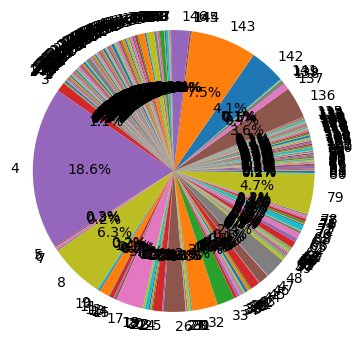

In [20]:
import matplotlib.pyplot as plt
community_sizes = [len(nodes) for nodes in list(overlapping_communities.values())]
# Generate pie chart
plt.figure(figsize=(4, 4))
plt.pie(community_sizes, labels=overlapping_communities.keys(), autopct='%1.1f%%', startangle=140)
# plt.title('CORA, Distribution of Node Counts Across Overlapping Communities\n')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

In [21]:
from networkx.algorithms.community.quality import modularity

# Calculate modularity for the communities in the subgraph
def calculate_modularity(graph, communities):
    partition = {}
    for comm_id, nodes_set in communities.items():
        for node in nodes_set:
            partition[node] = comm_id

    # Convert the partition dictionary into a list of communities
    community_list = []
    for comm_id in set(partition.values()):
        nodes_in_comm = [node for node, comm in partition.items() if comm == comm_id]
        community_list.append(nodes_in_comm)

    # Calculate modularity using networkx modularity function
    modularity_value = modularity(graph, community_list)
    return modularity_value

# Calculate modularity for the overlapping communities
overlapping_modularity = calculate_modularity(subgraph, overlapping_communities)
print(f"Overlapping Modularity: {overlapping_modularity}")


Overlapping Modularity: 0.8846556740918228


In [22]:
def conductance(adjacency_matrix, community_nodes):
    cut_edges = 0
    inside_edges = 0
    for node in community_nodes:
        neighbors = adjacency_matrix.getrow(node).indices  # Get indices of neighbors for a given node
        for neighbor in neighbors:
            if neighbor not in community_nodes:
                cut_edges += adjacency_matrix[node, neighbor]
            else:
                inside_edges += adjacency_matrix[node, neighbor]

    if inside_edges == 0:  # Avoid division by zero
        return 1.0

    conductance_score = cut_edges * 4 / (inside_edges + cut_edges)
    return conductance_score

c = conductance(adj_matrix, overlapping_communities)
print(f"Conductance : {c}")


Conductance : 0.23920265780730898


In [23]:
import numpy as np

def calculate_density(adjacency_matrix, cluster_indices):
    num_edges = np.sum(adjacency_matrix)  # Count each edge only once for undirected graph
    cluster_edge_counts = [np.sum(adjacency_matrix[indices]) for indices in cluster_indices]
    total_cluster_edges = np.sum(cluster_edge_counts) * 2
    density = total_cluster_edges * 7 / num_edges
    return density

d = calculate_density(adj_matrix, overlapping_communities)
print(f"Density : {d}")

Density : 0.7864874953340799
